In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets
from models.position_encoding import build_position_encoding_, build_position_encoding
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model, models_vit
from util.pos_embed import interpolate_pos_embed
from datasets.data_prefetcher import data_prefetcher
import torchvision

import cv2


from main import get_args_parser

In [2]:
parser = argparse.ArgumentParser('ViT Deformable DETR training and evaluation script', parents=[get_args_parser("debug", "2")])
args = parser.parse_args('')
model, _, _ = build_model(args)

In [3]:
if args.resume.startswith('https'):
    checkpoint = torch.hub.load_state_dict_from_url(
        args.resume, map_location='cpu', check_hash=True)
else:
    checkpoint = torch.load("../"+args.resume, map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
model.load_state_dict(checkpoint['model'], strict=False)

<All keys matched successfully>

In [4]:
model.to('cuda:0')

ViTDeformableDETRFull(
  (transformer): ViTDeformableTransformerFull(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, ele

In [5]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [6]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [7]:
len(CLASSES)

91

In [8]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [9]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [10]:
model.eval()

ViTDeformableDETRFull(
  (transformer): ViTDeformableTransformerFull(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, ele

In [11]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = 'https://render.fineartamerica.com/images/rendered/default/acrylic-print/10/7/hangingwire/break/images-medium-5/boats-at-rest-ullswater-lake-beautiful-lake-district-scene-cumbria-england-uk-michael-charles.jpg'
url = './images/cute-kittens.jpg'
im = Image.open(url)

In [12]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
with torch.no_grad():
    outputs = model([img.squeeze().to('cuda:0')])

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values >= min(torch.topk(probas.max(-1).values,1).values).item()

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep].to('cpu'), im.size)

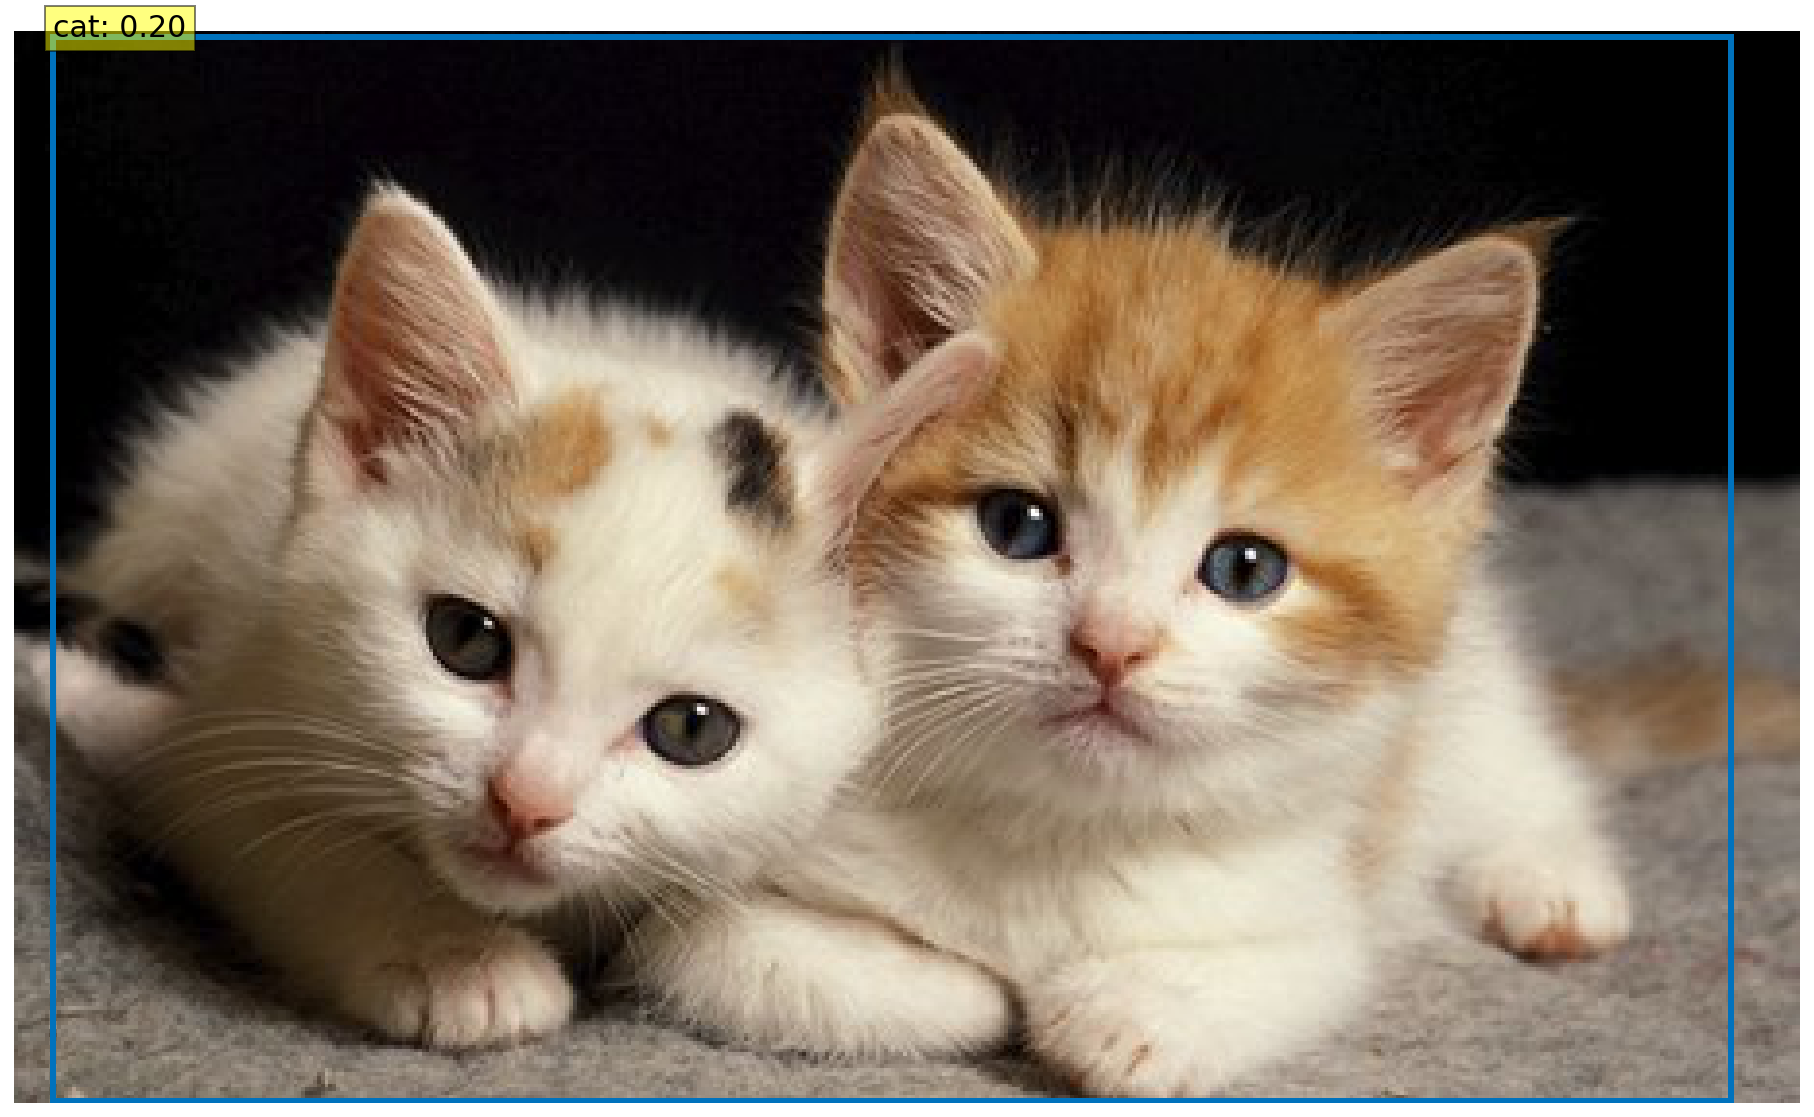

In [13]:
plot_results(im, probas[keep], bboxes_scaled)

In [14]:
# use lists to store the outputs via up-values
backbone_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone.backbone.register_forward_hook(
        lambda self, input, output: backbone_features.append(output[0])
    ),
    # # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
    # #     lambda self, input, output: enc_attn_weights.extend(output[1:])
    # # ),
    model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.extend(output[1:])
    ),
]

# propagate through the model
outputs = model([img.squeeze().to('cuda:0')])

for hook in hooks:
    hook.remove()

# don't need the list anymore
backbone_features = backbone_features[0]
# N, Len_q, n_heads, n_levels, n_points
# enc_sampling_location = enc_attn_weights[1]
# enc_attn_weights = enc_attn_weights[0]
dec_sampling_location = dec_attn_weights[1]
dec_attn_weights = dec_attn_weights[0]

In [15]:
for backbone_feature in backbone_features:
    print(backbone_feature.shape)

torch.Size([1, 256, 12, 20])
torch.Size([1, 256, 25, 41])
torch.Size([1, 256, 50, 83])
torch.Size([1, 256, 100, 166])


In [16]:
def nomarlize_sampling_location(sampling_location_):
    sampling_location = sampling_location_.clone()
    for idx_layer in range(sampling_location.shape[3]):
        for idx_offset in range(sampling_location.shape[4]):
            max_h = torch.max(sampling_location[:,:,:,idx_layer,idx_offset,0])
            min_h = torch.min(sampling_location[:,:,:,idx_layer,idx_offset,0])
            range_h = max_h-min_h
            sampling_location[:,:,:,idx_layer,idx_offset,0] = (sampling_location[:,:,:,idx_layer,idx_offset,0]-min_h)/range_h

            max_w = torch.max(sampling_location[:,:,:,idx_layer,idx_offset,1])
            min_w = torch.min(sampling_location[:,:,:,idx_layer,idx_offset,1])
            range_w = max_w-min_w
            sampling_location[:,:,:,idx_layer,idx_offset,1] = (sampling_location[:,:,:,idx_layer,idx_offset,1]-min_w)/range_w
    return sampling_location

In [17]:
# enc_sampling_location = nomarlize_sampling_location(enc_sampling_location)
dec_sampling_location = nomarlize_sampling_location(dec_sampling_location)

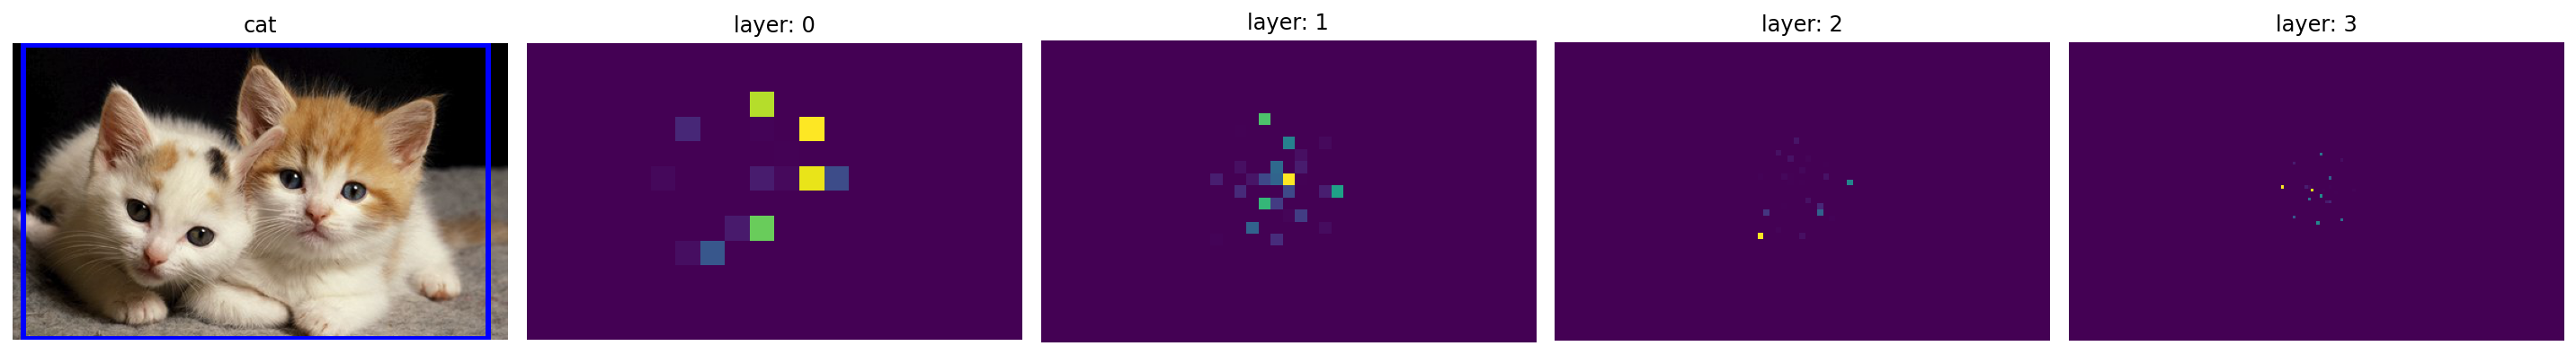

In [18]:
# get the feature map shape
fig, axs = plt.subplots(ncols=5, nrows=len(bboxes_scaled), figsize=(20, 20))
axs = axs[..., np.newaxis]
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                            fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
    for idx_layer, backbone_feature in enumerate(backbone_features):
        ax = ax_i[idx_layer+1]
        h, w = backbone_feature.shape[-2:]
        blank = np.zeros((h, w))
        for idx_offset in range(dec_attn_weights.shape[4]):
            for idx_head in range(dec_attn_weights.shape[2]):
                h_, w_ = int(torch.round(h*(dec_sampling_location[0, idx, idx_head, idx_layer, idx_offset, 1]))), int(torch.round(w*(dec_sampling_location[0, idx, idx_head, idx_layer, idx_offset, 0])))
                blank[h_-1, w_-1] += dec_attn_weights[0, idx, idx_head, idx_layer, idx_offset]
        blank /= 8
        ax.imshow(blank)
        ax.axis('off')
        ax.set_title(f'layer: {idx_layer}')
    fig.tight_layout()

In [23]:
transform_ = T.Compose([
    T.Resize(480),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
def draw_results(img, prob, boxes):
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,0), 2)
        cv2.putText(img, text, (int(xmin), int(ymin)),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,0,255),2)
    return img

In [26]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
        
    frame_pil = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame_pil = Image.fromarray(frame_pil)

    frame_pil = transform_(frame_pil)

    with torch.no_grad():
        outputs = model([img.squeeze().to('cuda:0')])

    # keep 3 pred with highest confident score
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values >= min(torch.topk(probas.max(-1).values,3).values).item()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep].to('cpu'), frame.shape[:2][::-1])

    frame = draw_results(frame, probas[keep], bboxes_scaled)
    # cv2.rectangle(frame, (1,3), (50,60), (255,0,0), 2)
    
    cv2.imshow('output', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()